In [1]:
#A Bayesian approach to A/B testing

import pymc as pm

p = pm.Uniform('p', lower=0, upper=1)

Couldn't import dot_parser, loading of dot files will not be possible.


In [53]:
#setting Constants

p_true = 0.05
N = 3000

#sample N Bernoulli random Variables from Ber(0.05)
#Each random variable has a 0.05 change of being 1.
#This is our data generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences
print occurrences.sum()

[False False False ..., False False False]
167


In [54]:
print "What is the observed frequency in Group A? %.4f" %occurrences.mean()
print "Does this equal the true freq? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0557
Does this equal the true freq? False


In [60]:
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

mcmc = pm.MCMC([p,obs])
mcmc.sample(18000,1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 5.7 sec

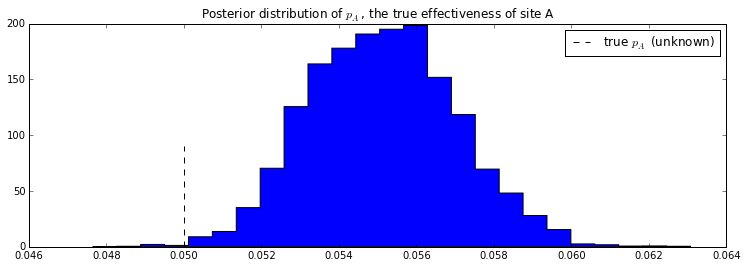

In [61]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle='--', label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [63]:
true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 750

#generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)

print "Obs from Site A:", observations_A[:30].astype(int), '...'
print "Obs from Site B:", observations_B[:30].astype(int), '...'



 Obs from Site A: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] ...


In [64]:
print observations_A.mean()
print observations_B.mean()

0.0533333333333
0.0386666666667


In [65]:
#set up pymc model
#Lets continue to assume uniform prior distributions

p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


#Define a deterministic delta function

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

#Let's create some simulated observations, 
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

#Lets generate the simulations

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.6 sec

In [66]:
#Once we have observations we can generate posterior distributions

p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]



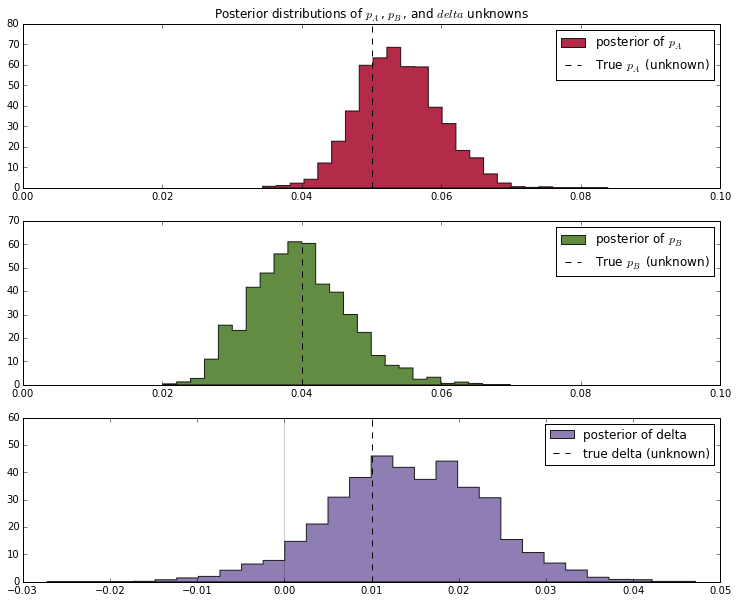

In [68]:
#And now we plot for some visual understanding of the posterior vs prior

figsize(12.5, 10)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype="stepfilled", bins=25, alpha=0.85,
        label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle='--', label="True $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and $delta$ unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype="stepfilled", bins=25, alpha= 0.85,
        label="posterior of $p_B$", color="#467821",normed=True)
plt.vlines(true_p_B, 0, 60, linestyle='--', label="True $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype="stepfilled", bins=30, alpha=0.85,
        label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");




In [69]:
#Since we are comparing two options: Site A and B we can measure th
#difference between the performance in the site
#Since Delta equals A-B we can know that any value of a negative delta
#Suggests that B did better than A
#we can take a mean of the values that are greater than
#and less than zero and get some sense of how likely our results are accurate
print "Probability site A is WORSE than site B: %.3f" % \
        (delta_samples < 0).mean()
    
print "Probability site B is WORSE than site A: %.3f" % \
        (delta_samples > 0).mean()




Probability site A is WORSE than site B: 0.057
Probability site B is WORSE than site A: 0.943
